<h2>Booter Blacklist - SURFnet's case (the Dutch NREN)</h2> 
<h3>Data analysis to support the usage of Booter blacklist (booterblacklist.com)</h3> 

<br>
<div id="TOC">
<ul>

<li><a href="#1">1. Preamble & Pre-analysis</a></li>
<ul>
<li><a href="#1.1">1.1. What are the libraries that we use to analyse the data?</a></li>
<li><a href="#1.2">1.2. How the data looks like? [loding the raw data]</a></li>
<li><a href="#1.3">1.3. What should be formated/fix/added to facilitate our analisis?</a></li>
<li><a href="#1.4">1.4. What are the outliers that should be *removed from the analysis?</a></li>
<li><a href="#1.5">1.5. Defining the NEW data frame (excluding the outlier)</a></li>
<li><a href="#1.6">1.6. How many different record types are there in the (remaining) data frame? and removing the outlier client?</a></li> 
</ul>

<li><a href="#2">2. The analysis</a></li>
<ul>
<li><a href="#2.0.1">Defining 4-months periods</a></li>

<li><a href="#2.1">2.1. Booters analysis</a></li>
<ul>
<li><a href="#2.1.1">2.1.1. How many distinct Booters were accessed by users in total? in Q1, Q2 and Q3?</a></li>
<li><a href="#2.1.2">2.1.2. What is distribution of the number of access to Booters?</a></li>
<li><a href="#2.1.3">2.1.3. What are the most accessed Booters? and for each 4-months period?</a></li>
<li><a href="#2.1.4">2.1.4. What are the medians of access to the most accessed Booters?</a></li>
</ul>

<li><a href="#2.2.">2.2. Users Analysis</a></li>
<ul>
<li><a href="#2.2.1.">2.2.1. How many users are in the data?</a></li>
<li><a href="#2.2.2.">2.2.2. What is the cumulative distribution of the requests per users?</a></li>
<li><a href="#2.2.3.">2.2.3. Which are the top10 clients?and how many times each top10 client request for a Booter?</a></li>
<li><a href="#2.2.4.">2.2.4. How many accesses to Booters each top 10 client performed? How is the overall distribution of access to different Booters each client performed?</a></li>
<li><a href="#2.2.5">2.2.5. What are the medians of access to the most accessed Booters?</a></li>
</ul>

</ul>
</div>


<div id="1"><h1><a href="#TOC">1. Preamble & Pre-analysis</a></h1></div>

<div id="1.1"><h2><a href="#TOC">1.1. What are the libraries that we use to analyse the data?</a></h2></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid.inset_locator import inset_axes

from itertools import cycle, islice

# Style
mystyle = list(islice(cycle(['s-','ro-','y^-','c*-','r-o', 'g--^', 'b:*', 'm-.D', 'k:o']), None, 18))

#This is the color template that I use. For more information https://personal.sron.nl/~pault/colourschemes.pdf
mycolors4 = list(islice(cycle(['#4477AA','#117733','#DDCC77','#CC6677']), None, 4)) # we can change the '4' len(df that you want plot)
mycolors12 = list(islice(cycle(['#332288','#6699CC','#88CCEE','#44AA99','#117733','#999933','#DDCC77','#661100','#CC6677','#AA4466','#882255','#AA4499']), None, 12))

<div id="1.2"><h2><a href="#TOC">1.2. How the data looks like? [loding the raw data]</a></h2></div>

In [2]:
# Loading the data
# In pandas a dataset is loaded as "data frame" for this reason we use the acronym "df"
# We also skipp the lines that have more columns than expected ( we just need this 6 columns)
df0 = pd.read_csv('../data/20160530_surfnet_booters.txt', error_bad_lines=False, sep=',',\
                  names = ['timestamp', 'recordtype', 'client', 'in','querytype','value'])

# Presenting the first 5 lines
df0.head(10)

,timestamp,recordtype,client,in,querytype,value
0,1434735481,Q(Q),c861aaa8307395e94c0bc1d88e9846ff1680712521986...,IN,A,quezstresser.com.
1,1434735481,Q(R),c861aaa8307395e94c0bc1d88e9846ff1680712521986...,IN,A,quezstresser.com.
2,1434735481,R(ANS),c861aaa8307395e94c0bc1d88e9846ff1680712521986...,IN,A,185.62.190.40
3,1434737327,Q(Q),209cd9935519df117524240334f11c3ec3ee5d9932ffb...,IN,A,booter.xyz.
4,1434737327,Q(R),209cd9935519df117524240334f11c3ec3ee5d9932ffb...,IN,A,booter.xyz.
5,1434737327,R(ANS),209cd9935519df117524240334f11c3ec3ee5d9932ffb...,IN,A,104.28.26.6
6,1434737327,R(ANS),209cd9935519df117524240334f11c3ec3ee5d9932ffb...,IN,A,104.28.27.6
7,1434737327,R(ADD),209cd9935519df117524240334f11c3ec3ee5d9932ffb...,UNSPECIFIED,UNSPECIFIED,EDNS version 0
8,1434738950,Q(Q),c861aaa8307395e94c0bc1d88e9846ff1680712521986...,IN,A,quezstresser.com.
9,1434738950,Q(R),c861aaa8307395e94c0bc1d88e9846ff1680712521986...,IN,A,quezstresser.com.


<div id="1.3"><h2><a href="#TOC">1.3. What should be formated/fix/added to facilitate our analisis?</a></h2></div>

In [3]:
# Converting the collumn 'value' to lower case and remove 'www'.
# "www.booter.xyz." is the same as "booter.xyz"
df0['value'] = map(lambda x: x.lower().replace('www.','',-1), df0['value'])

# Converting epoch timestamp into date.
df0['timestamp'] = pd.to_datetime(df0['timestamp'],unit='s')

# Adding a column with 1's
df0['unit'] = 1 

<div id="1.4"><h2><a href="#TOC">1.4. What are the outliers that should be *removed from the analysis?</a></h2></div>

In [4]:
df0[df0['recordtype']==' Q(Q)']['client'].value_counts()[0:10]

 b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1    4384
 7b4f45b838b71c0b422ac872c22b31650d8a8765afcc003b8b3b6ca5b2cbed55     985
 561e20341386f1b637011983cd6b800e4e77496fd22c14843bfe8521706e68ad     933
 18f9eec93778aa08e31a56b1f416f0d8704db9a56d36f3eebefeac80c7cb2cc5     672
 8acd6af477c9b86d6ef54ee4dbf9a4910396bc7c9ad64d4c22b89e77626bf72a     580
 6936a119cf12e9551e0f08ba9e71750108f4807cc522fbb23de6b6240e07eb38     412
 0f972ef7b4abd26a505e0d0aa8d997f01a9ac75a5a4b0f8ec31852fd8979e74e     380
 3d871e5389b8434ca72af572b8885e3c9104897cb7ce0f5d5623e4c6bdcac15f     371
 7f79658a9cc4e7e34f0c8ca40de8bfa2f76fa33f6653df351da3325c9e3c8781     370
 6a08a0ed68df7495e74392068398313951d40c84b7f000d5aeedc01d86d0e1f3     340
Name: client, dtype: int64

- The first client identified by 'b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1' is clearly an outlier. By talking with our SURFnet they disclosured that such client is a TOR exit node. They also provide the identifier of a second exit node: '4fcc1341c071b5b7e0159696766868fbb63728e7db978c153ccc47df386410c1'. Although we analyse the behaviour of both clients in the end of this notebook, we remove then from the main analysis of the dataset.

<div id="1.5"><h2><a href="#TOC">1.5. Defining the NEW data frame (excluding the outlier)</a></h2></div>   

In [5]:
df = df0[(df0['client']!=' b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1') & \
         (df0['client']!=' 4fcc1341c071b5b7e0159696766868fbb63728e7db978c153ccc47df386410c1')]

<div id="1.6"><h2><a href="#TOC">1.6. How many different record types are there in the (remaining) data frame? and removing the outlier client?</a></h2></div>

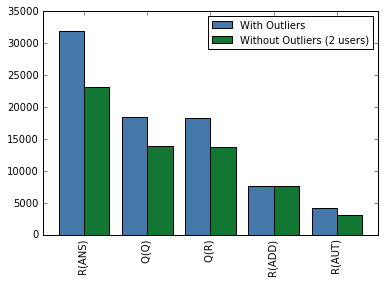

In [6]:
# Data
records_withoutliers= df0['recordtype'].value_counts()
records_withoutoutliers=df['recordtype'].value_counts()

merged = pd.concat([records_withoutliers,records_withoutoutliers], axis=1)
merged.columns = ['With Outliers','Without Outliers (2 users)']
merged_sorted = merged.sort_values(['With Outliers','Without Outliers (2 users)'], ascending=[False,True])

# Plotting
fig = plt.figure()
ax = merged_sorted.plot.bar(color=mycolors4,width = .8)
ax.legend(prop={'size':10})

<div id="2"><h1><a href="#TOC">2. The analysis</a></h1></div>

<div id="2.0.1"><h2><a href="#TOC">2.0.1. Defining 4-months periods</a></h2></div>

In [7]:
indexed_df = df.set_index(['timestamp'])

df_q1=indexed_df['2015-06-01':'2015-09-30']
df_q2=indexed_df['2015-10-01':'2016-01-31']
df_q3=indexed_df['2016-02-01':]

<div id="2.1"><h1><a href="#TOC">2.1. Booters analysis</a></h1></div>

<div id="2.1.1"><h2><a href="#TOC">2.1.1. How many distinct Booters were accessed by users in total? in Q1, Q2 and Q3?</a></h2></div>


In [8]:
total_booters_outliers=len(df0[df0['recordtype']==' Q(Q)']['value'].value_counts())

total_booters=len(df[df['recordtype']==' Q(Q)']['value'].value_counts())
booters_q1=len(df_q1[df_q1['recordtype']==' Q(Q)']['value'].value_counts())
booters_q2=len(df_q2[df_q2['recordtype']==' Q(Q)']['value'].value_counts())
booters_q3=len(df_q3[df_q3['recordtype']==' Q(Q)']['value'].value_counts())

# Printing
total_booters_outliers,total_booters,booters_q1,booters_q2,booters_q3

(224, 190, 108, 120, 91)

- Looks like that the outliers (that are the TOR nodes) accessed 34 Booters never accessed by the other 'normal' users. 

<div id="2.1.2"><h2><a href="#TOC">2.1.2. What is distribution of the number of access to Booters?</a></h2></div>

In [9]:
serie = df['value'][df['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist = np.linspace(0.,1.,len(serie))
cdf = pd.Series(cum_dist, index=serie)

serie_q1 = df_q1['value'][df_q1['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q1 = np.linspace(0.,1.,len(serie_q1))
cdf_q1 = pd.Series(cum_dist_q1, index=serie_q1)

serie_q2 = df_q2['value'][df_q2['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q2 = np.linspace(0.,1.,len(serie_q2))
cdf_q2 = pd.Series(cum_dist_q2, index=serie_q2)

serie_q3 = df_q3['value'][df_q3['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q3 = np.linspace(0.,1.,len(serie_q3))
cdf_q3 = pd.Series(cum_dist_q3, index=serie_q3)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


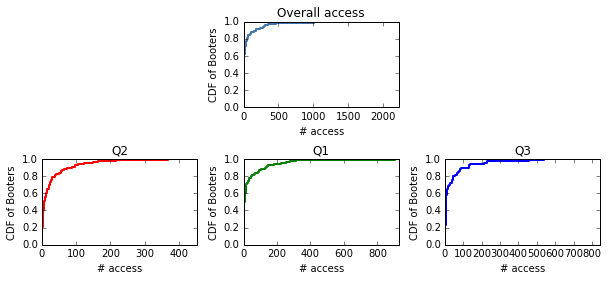

In [10]:
# Plot
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.6,wspace=0.3)

ax1 = plt.subplot2grid((2,3), (0,1))
cdf.plot(lw=2, ax=ax1, drawstyle='steps',color='#4477aa', title="Overall access")
ax1.set_xlabel("# access")
ax1.set_ylabel("CDF of Booters")

ax2 = plt.subplot2grid((2,3), (1,0))
cdf_q1.plot(lw=2, drawstyle='steps',color='r', title="Q2")
ax2.set_xlabel("# access")
ax2.set_ylabel("CDF of Booters")

ax3 = plt.subplot2grid((2,3), (1,1))
cdf_q2.plot(lw=2, drawstyle='steps',color='g', title="Q1")
ax3.set_xlabel("# access")
ax3.set_ylabel("CDF of Booters")

ax4 = plt.subplot2grid((2,3), (1,2))
cdf_q3.plot(lw=2, drawstyle='steps',color='b', title="Q3")
ax4.set_xlabel("# access")
ax4.set_ylabel("CDF of Booters")

fig.show()

<div id="2.1.3"><h2><a href="#TOC">2.1.3. What are the most accessed Booters? and for each 4-months period?</a></h2></div>

In [11]:
top10booters_count = df['value'][df['recordtype']==' Q(Q)'].value_counts()[:10]
top10booters=top10booters_count.index.tolist()

top10booters_q1_count = df_q1['value'][df_q1['recordtype']==' Q(Q)'] .value_counts()[:10]
top10booters_q1=top10booters_q1_count.index.tolist()

top10booters_q2_count = df_q2['value'][df_q2['recordtype']==' Q(Q)'].value_counts()[:10]
top10booters_q2=top10booters_q2_count.index.tolist()

top10booters_q3_count = df_q3['value'][df_q3['recordtype']==' Q(Q)'] .value_counts()[:10]
top10booters_q3=top10booters_q3_count.index.tolist()

q1=pd.DataFrame(top10booters_q1)
q2=pd.DataFrame(top10booters_q2)
q3=pd.DataFrame(top10booters_q3)
alltop10=list(pd.concat([q1,q2,q3]).drop_duplicates().values.flatten())

booters_perweek = pd.pivot_table(df[df['recordtype']==' Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='7D'), \
                    columns='value', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

booters_permonth = pd.pivot_table(df[df['recordtype']==' Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='1M'), \
                    columns='value', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

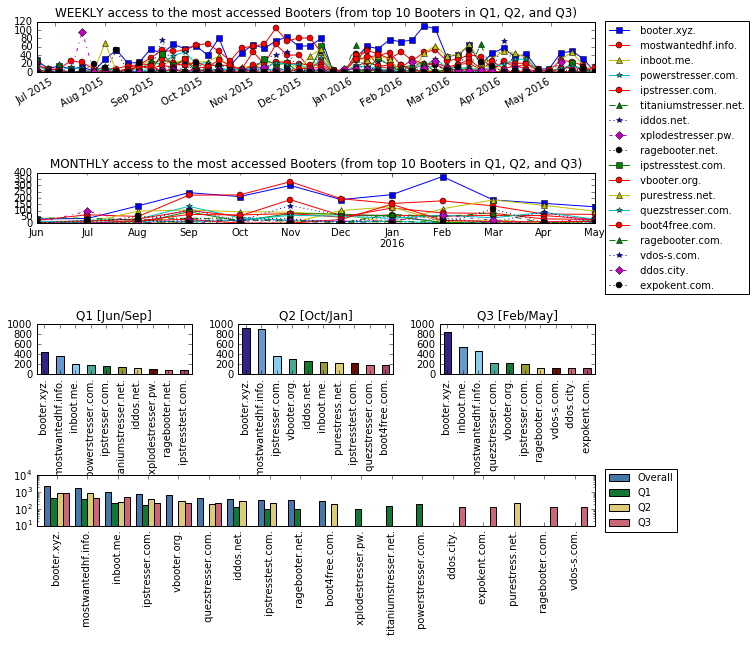

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=2,wspace=0.3)

ax1 = plt.subplot2grid((4,3), (0,0), colspan=3)
booters_perweek[alltop10].plot(ax=ax1,style=mystyle, title="WEEKLY access to the most accessed Booters (from top 10 Booters in Q1, Q2, and Q3)", legend=False)
ax1.legend(loc='center left',prop={'size':10},bbox_to_anchor=(1.01, -1.7),numpoints=1)
ax1.set_xlabel("")

ax2 = plt.subplot2grid((4,3), (1,0), colspan=3)
booters_permonth[alltop10].plot(ax=ax2,style=mystyle, title="MONTHLY access to the most accessed Booters (from top 10 Booters in Q1, Q2, and Q3)", legend=False)
ax2.set_xlabel("")

ax3 = plt.subplot2grid((4,3), (2,0))
top10booters_q1_count.plot.bar(color=mycolors12,ax=ax3, title="Q1 [Jun/Sep]",ylim=(0,1000))

ax4 = plt.subplot2grid((4,3), (2,1))
top10booters_q2_count.plot.bar(color=mycolors12,ax=ax4, title="Q2 [Oct/Jan]")

ax5 = plt.subplot2grid((4,3), (2,2))
top10booters_q3_count.plot.bar(color=mycolors12,ax=ax5, title="Q3 [Feb/May]",ylim=(0,1000))

ax6 = plt.subplot2grid((4,3), (3,0), colspan=3)
merged = pd.concat([top10booters_count, top10booters_q1_count,top10booters_q2_count,top10booters_q3_count], axis=1)
merged.columns = ['Overall','Q1', 'Q2','Q3']
merged.sort_values(['Overall','Q1'], ascending=[False,True]).plot.bar(color=mycolors4,ax=ax6,logy=True,width = .8)
ax6.legend(loc='center left',prop={'size':10},bbox_to_anchor=(1.01, 0.5),numpoints=1)

# fig.savefig('~/Desktop/booters_per_quarter.eps', bbox_inches='tight',format='eps', dpi=1200)

<div id="2.1.4"><h2><a href="#TOC">2.1.4. What are the medians of access to the most accessed Booters?</a></h2></div>

In [13]:
medians = pd.concat([booters_perweek[alltop10].median(),booters_permonth[alltop10].median()], axis=1)
medians.columns = ['Weekly','Monthly']
medians.sort_values(['Monthly','Weekly'], ascending=[False,True])

,Weekly,Monthly
value,,
booter.xyz.,45.0,186.5
mostwantedhf.info.,29.0,147.5
inboot.me.,16.5,93.5
ipstresser.com.,14.0,59.5
vbooter.org.,11.0,57.5
quezstresser.com.,6.5,35.5
ragebooter.net.,3.0,27.5
vdos-s.com.,2.5,18.0
ddos.city.,3.0,16.5


<div id="2.2."><h1><a href="#TOC">2.2. Users Analysis</a></h1></div>

<div id="2.2.1."><h2><a href="#TOC">2.2.1. How many users are in the data?</a></h2></div>

In [14]:
total_users_outliers=len(df0[df0['recordtype']==' Q(Q)']['client'].value_counts())

total_users=len(df[df['recordtype']==' Q(Q)']['client'].value_counts())
users_q1=len(df_q1[df_q1['recordtype']==' Q(Q)']['client'].value_counts())
users_q2=len(df_q2[df_q2['recordtype']==' Q(Q)']['client'].value_counts())
users_q3=len(df_q3[df_q3['recordtype']==' Q(Q)']['client'].value_counts())

# Printing
total_users_outliers,total_users,users_q1,users_q2,users_q3

(441, 439, 180, 245, 197)

<div id="2.2.2."><h2><a href="#TOC">2.2.2. What is the cumulative distribution of the requests per users?</a></h2></div>

In [15]:
serie = df['client'][df['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist = np.linspace(0.,1.,len(serie))
cdf = pd.Series(cum_dist, index=serie)

serie_q1 = df_q1['client'][df_q1['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q1 = np.linspace(0.,1.,len(serie_q1))
cdf_q1 = pd.Series(cum_dist_q1, index=serie_q1)

serie_q2 = df_q2['client'][df_q2['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q2 = np.linspace(0.,1.,len(serie_q2))
cdf_q2 = pd.Series(cum_dist_q2, index=serie_q2)

serie_q3 = df_q3['client'][df_q3['recordtype']==' Q(Q)'].value_counts().sort_values()
cum_dist_q3 = np.linspace(0.,1.,len(serie_q3))
cdf_q3 = pd.Series(cum_dist_q3, index=serie_q3)

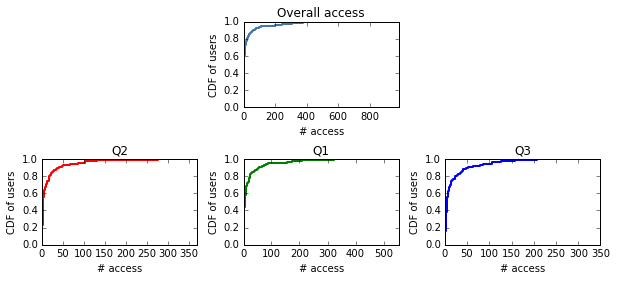

In [16]:
# Plot
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.6,wspace=0.3)

ax1 = plt.subplot2grid((2,3), (0,1))
cdf.plot(lw=2, ax=ax1, drawstyle='steps',color='#4477aa', title="Overall access")
ax1.set_xlabel("# access")
ax1.set_ylabel("CDF of users")

ax2 = plt.subplot2grid((2,3), (1,0))
cdf_q1.plot(lw=2, drawstyle='steps',color='r', title="Q2")
ax2.set_xlabel("# access")
ax2.set_ylabel("CDF of users")

ax3 = plt.subplot2grid((2,3), (1,1))
cdf_q2.plot(lw=2, drawstyle='steps',color='g', title="Q1")
ax3.set_xlabel("# access")
ax3.set_ylabel("CDF of users")

ax4 = plt.subplot2grid((2,3), (1,2))
cdf_q3.plot(lw=2, drawstyle='steps',color='b', title="Q3")
ax4.set_xlabel("# access")
ax4.set_ylabel("CDF of users")

fig.show()

<div id="2.2.3."><h2><a href="#TOC">2.2.3. Which are the top10 clients?and how many times each top10 client request for a Booter?</a></h2></div>

In [17]:
top10users_count = df['client'][df['recordtype']==' Q(Q)'].value_counts()[:10]
top10users=top10users_count.index.tolist()

top10users_q1_count = df_q1['client'][df_q1['recordtype']==' Q(Q)'] .value_counts()[:10]
top10users_q1=top10users_q1_count.index.tolist()

top10users_q2_count = df_q2['client'][df_q2['recordtype']==' Q(Q)'].value_counts()[:10]
top10users_q2=top10users_q2_count.index.tolist()

top10users_q3_count = df_q3['client'][df_q3['recordtype']==' Q(Q)'] .value_counts()[:10]
top10users_q3=top10users_q3_count.index.tolist()

q1=pd.DataFrame(top10users_q1)
q2=pd.DataFrame(top10users_q2)
q3=pd.DataFrame(top10users_q3)
alltop10=list(pd.concat([q1,q2,q3]).drop_duplicates().values.flatten())

users_perweek = pd.pivot_table(df[df['recordtype']==' Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='7D'), \
                    columns='client', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

users_permonth = pd.pivot_table(df[df['recordtype']==' Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='1M'), \
                    columns='client', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

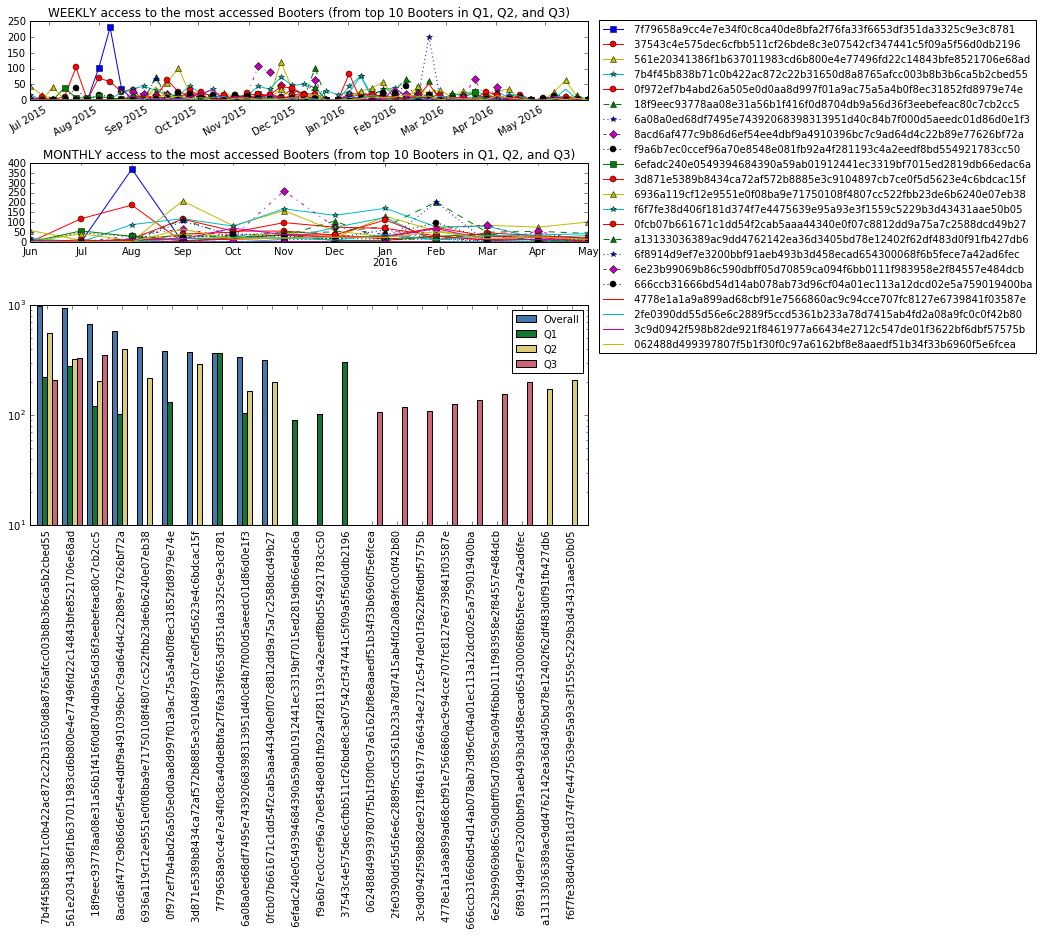

In [18]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.8,wspace=0.3)

ax1 = plt.subplot2grid((4,3), (0,0), colspan=3)
users_perweek[alltop10].plot(ax=ax1,style=mystyle, title="WEEKLY access to the most accessed Booters (from top 10 Booters in Q1, Q2, and Q3)", legend=False)
ax1.legend(loc='center left',prop={'size':10},bbox_to_anchor=(1.01, -1.1),numpoints=1)
ax1.set_xlabel("")

ax2 = plt.subplot2grid((4,3), (1,0), colspan=3)
users_permonth[alltop10].plot(ax=ax2,style=mystyle, title="MONTHLY access to the most accessed Booters (from top 10 Booters in Q1, Q2, and Q3)", legend=False)
ax2.set_xlabel("")

# ax3 = plt.subplot2grid((4,3), (2,0))
# top10users_q1_count.plot.bar(color=mycolors12,ax=ax3, title="Q1 [Jun/Sep]",ylim=(0,1000))

# ax4 = plt.subplot2grid((4,3), (2,1))
# top10users_q2_count.plot.bar(color=mycolors12,ax=ax4, title="Q2 [Oct/Jan]")

# ax5 = plt.subplot2grid((4,3), (2,2))
# top10users_q3_count.plot.bar(color=mycolors12,ax=ax5, title="Q3 [Feb/May]",ylim=(0,1000))

ax6 = plt.subplot2grid((4,3), (2,0), colspan=3, rowspan=2) 
merged = pd.concat([top10users_count, top10users_q1_count,top10users_q2_count,top10users_q3_count], axis=1)
merged.columns = ['Overall','Q1', 'Q2','Q3']
merged.sort_values(['Overall','Q1'], ascending=[False,True]).plot.bar(color=mycolors4,ax=ax6,logy=True,width = .8)
ax6.legend(prop={'size':10})


<div id="2.2.4."><h2><a href="#TOC">2.2.4. How many accesses to Booters each top 10 client performed? How is the overall distribution of access to different Booters each client performed?</a></h2></div>

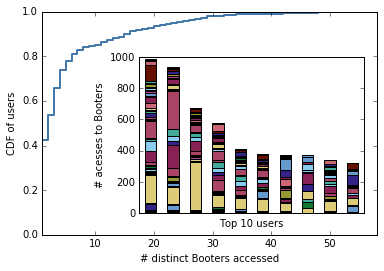

In [19]:
# DATA (for the main plot)
ser = df[df['recordtype']==' Q(Q)'].groupby(['client', 'value']).size().reset_index().groupby('client').count().ix[:,0].sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
cdf = pd.Series(cum_dist, index=ser)

# PLOT (main)
fig = plt.figure()
ax = fig.add_subplot(111)
cdf.plot(lw=2,ax=ax,drawstyle='steps',color='#4477aa', title="").set_xlabel("")
ax.set_xlabel("# distinct Booters accessed")
ax.set_ylabel("CDF of users")

# DATA (for the subplot inside)
clients_permonth = pd.pivot_table(df[df['recordtype']==' Q(Q)'], index='client', columns='value', values='unit', aggfunc=np.sum, fill_value=0)

# PLOT 
box = ax.get_position()
fig2 = plt.gcf()
fig2.transFigure.inverted().transform(ax.transAxes.transform([0,0])) ##doesn't matter this numbers
x=0.35
y=0.2
width=box.width*0.67
height=box.height*0.7
ax1 = fig2.add_axes([x,y,width,height],axisbg='w') #x,y,width,height
clients_permonth.ix[top10users].plot(kind='bar',ax=ax1, stacked=True, legend=False, color=mycolors12, title="")
ax1.axes.get_xaxis().set_ticks([])
ax1.set_xlabel("Top 10 users")
ax1.set_ylabel("# acesses to Booters")
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)

fig.show()
#fig.savefig('/Users/santannajj/Desktop/booters_accessed_top10users.eps', bbox_inches='tight',format='eps', dpi=1200)

<div id="2.2.5"><h2><a href="#TOC">2.2.5. What are the medians of access to the most accessed Booters?</a></h2></div>

In [20]:
medians = pd.concat([users_perweek[alltop10].median(),users_permonth[alltop10].median()], axis=1)
medians.columns = ['Weekly','Monthly']
medians.sort_values(['Monthly','Weekly'], ascending=[False,True])

,Weekly,Monthly
client,,
7b4f45b838b71c0b422ac872c22b31650d8a8765afcc003b8b3b6ca5b2cbed55,15.0,80.0
561e20341386f1b637011983cd6b800e4e77496fd22c14843bfe8521706e68ad,11.5,73.5
18f9eec93778aa08e31a56b1f416f0d8704db9a56d36f3eebefeac80c7cb2cc5,10.0,49.0
8acd6af477c9b86d6ef54ee4dbf9a4910396bc7c9ad64d4c22b89e77626bf72a,4.0,29.0
0f972ef7b4abd26a505e0d0aa8d997f01a9ac75a5a4b0f8ec31852fd8979e74e,3.0,24.5
6936a119cf12e9551e0f08ba9e71750108f4807cc522fbb23de6b6240e07eb38,4.0,22.0
3d871e5389b8434ca72af572b8885e3c9104897cb7ce0f5d5623e4c6bdcac15f,0.0,20.0
4778e1a1a9a899ad68cbf91e7566860ac9c94cce707fc8127e6739841f03587e,1.5,19.0
2fe0390dd55d56e6c2889f5ccd5361b233a78d7415ab4fd2a08a9fc0c0f42b80,2.0,18.5
